In [16]:
import csv
import json
import os
import re
import sys

from PIL import Image, ImageFilter
import imageio
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from scipy import ndimage as ndi
from skimage import feature
from scipy.fftpack import rfft, irfft, fftfreq, rfftfreq
from scipy import interpolate

def file_tree(start):
    """Generate file list in directory"""
    file_list = []
    for root, dirs, files in os.walk(start):
        for f in files:
            if f[0] != '.':
                file_list.append(f)
    return file_list


def process_data(data):
    """Process JSON data"""
    attr = data['attributes']

    timestamp = attr['timestamp']
    message = attr['message']
    author = attr['from']
    turbo = attr['tags']['turbo']
    sub = attr['tags']['subscriber']

    try:
        emotes = attr['tags']['emotes']
        emote_count = sum([len(emotes[key]) for key in emotes.keys()])
    except:
        emote_count = 0
    
    row = {
        'timestamp': timestamp,
        'author': author,
        'message': message,
        'turbo': turbo,
        'sub': sub,
        'emote_count': emote_count
    }

    return row


def high_pass_filter(freq, amp, min_freq):
    df = pd.DataFrame(amp, index=freq, columns=['Amplitude'])
    df = df.copy()
    df[df.index < min_freq] = 0
    return df

def low_pass_filter(freq, amp, max_freq):
    df = pd.DataFrame(amp, index=freq, columns=['Amplitude'])
    df = df.copy()
    df[df.index > max_freq] = 0
    return df

def round_to_val(x, val=30):
    return int(np.round(x/val) * val)

In [17]:
# Get file list
start = '/Volumes/Passport/LiveBeat/chat/v82878048'
file_list = file_tree(start)
df = []

# Aggregate files into dictionary
for file in file_list:
    get_path = os.path.join(start, file)
    with open(get_path) as f:
        # Format line and separate multiple JSON strings with commas
        line = '[{}]'.format(f.readline()).replace('}}{', '}},{')
        data = json.loads(line)[0]

        for message in data['data']:
            df.append(process_data(message))

# Create data frame from chat data and convert ms to s
df = pd.DataFrame(df)
minimum = df['timestamp'].min()
maximum = df['timestamp'].max()
df['timestamp'] = df['timestamp'].apply(lambda x: x - minimum)
df['secondstamp'] = df['timestamp'].apply(lambda x: int(round(x/1000)))

# Create chat frequency data frame where index is no. of seconds into video
chat_freq = df['secondstamp'].value_counts().sort_index()
# chat_freq = pd.DataFrame(chat_freq)
chat_freq.columns = ['frequency']
cf_copy = chat_freq.copy()

In [18]:
for i in np.arange(0, df['secondstamp'].max(), 30):
    section = df.loc[(df['secondstamp'] >= i) & (df['secondstamp'] < i+30)]
    print(section['emote_count'].value_counts().sum())

245
172
125
101
105
86
111
164
98
136
115
110
85
150
105
102
104
92
92
131
117
224
116
118
340
267
207
238
172
237
119
69
59
71
79
142
85
110
140
64
76
104
436
172
77
106
78
99
133
69
70
90
96
212
145
91
116
125
153
206
149
235
146
162
183
263
439
266
199
199
242
253
218
103
152
114
280
164
151
266
253
129
106
134
298
242
174
348
234
257
268
156
170
306
234
166
226
183
139
215
184
90
104
302
268
176
108
196
204
209
255
217
87
154
219
86
110
96
74
359
159
107
128
300
134
146
180
101
180
125
138
115
174
131
201
166
193
78
148
131
99
78
93
213
274
212
214
78
102
101
95
98
93
162
268
334
172
162
247
211
245
312
172
222
144
183
90
102
117
198
152
112
87
141
120
81
98
124
205
100
230
155
215
142
242
407
330
385
350
354
422
242
211
291
226
272
415
292
382
363
223
210
308
283
318
249
280
382
228
182
252
339
362
382
323
352
422
434
366
297
352
296
348
290
286
368
285
371
410
378
304
401
358
343
353
307
214
326
401
420
353
210
227
215
239
214
231
120
308
303
270
315
129
85
92
176
65
117
147
228


In [19]:
# Set filename
filename = '/Volumes/Passport/LiveBeat/video/dota2ti_v82878048_720p30.mp4'

# Get video id
video_id = re.findall('v\d+', filename)[0]

# Open file handle
vid = imageio.get_reader(filename, 'ffmpeg')

# Get metadata
meta = vid.get_meta_data()
fps = int(meta['fps'])
nframes = meta['nframes']
frames = np.arange(0, int(nframes), 1)

# Close video
vid.close()

# Convert frames to seconds and initialize data frame
values = [0] * int(len(frames)/fps)
df = pd.DataFrame(values).reset_index()
df.columns = ['second', 'game']
smear_df = df.copy()

# Import timecode data
# timecodes = pd.read_csv('./timecodes/timecodes_v82878048.csv', names=['start', 'stop'])
# timecodes = timecodes.astype(int)

timecodes = pd.DataFrame([[57600,120600],
[205200,334800],
[338400,340200],
[345600,347400],
[450000,451800],
[453600,574200],
[657000,790200],
[793800,795600],
[927000,1200600],
[1297800,1436400],
[1521000,1522800],])
timecodes.columns = ['start', 'stop']

# Smear timecodes to remove anything < 30 seconds long
smear_tc = timecodes[timecodes['stop'] - timecodes['start'] >= 30000].reset_index(drop=True)

# Run through smeared timecodes and flip switches on correct seconds of video
for i in smear_tc.index:
    row = smear_tc.iloc[i][['start', 'stop']]
    start = row[0]/fps
    stop = row[1]/fps
    df.loc[(df.index >= start) & (df.index < stop), 'game'] = 1

In [20]:
print(len(chat_freq.index))
print(len(df.index))
chat_freq.loc[(chat_freq.index == df.index) and (df['game'] == 0), 'frequency'] = 0
fig, ax1 = plt.subplots(figsize=(18,2))
ax2 = ax1.twinx()
ax1.plot(df.index, df['game'], '.b')
ax2.plot(chat_freq.index, chat_freq['frequency'], '-r')

24380
25430


ValueError: Lengths must match to compare

KeyError: 'frequency'

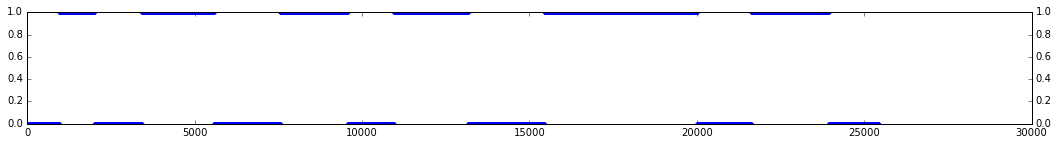

In [21]:
fig, ax1 = plt.subplots(figsize=(18,2))
ax2 = ax1.twinx()
ax1.plot(df.index, df['game'], '.b')
ax2.plot(chat_freq.index, pd.DataFrame(chat_freq['frequency']).rolling(window=200, win_type='hamming').mean(), '-r')

In [ ]:
df_copy = df[0:len(cf_copy)]
cf_copy['game'] = df_copy['game']
cf_copy.loc[cf_copy['game'] != 1] = 0

fig, ax1 = plt.subplots(figsize=(18,2))
ax2 = ax1.twinx()
ax1.plot(df.index, df['game'], '.b')
ax2.plot(cf_copy.index, cf_copy['frequency'], '-r')